In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
raw_data = pd.read_csv('/content/drive/MyDrive/Google Colab Notebooks/Mini Sem 8/dataset/large sample/IBM_2years_15Min (1).csv')

In [3]:
print(raw_data.shape)
raw_data.head()

(21541, 7)


,Unnamed: 0,time,open,high,low,close,volume
0,0,2022-03-25 19:30:00,131.300,131.30,131.300,131.30,1000
1,1,2022-03-25 18:00:00,131.300,131.30,131.300,131.30,100
2,2,2022-03-25 17:00:00,131.340,131.35,131.340,131.35,1427
3,3,2022-03-25 16:45:00,131.326,131.35,131.326,131.35,1326
4,4,2022-03-25 16:15:00,131.350,131.40,131.350,131.40,56109


In [4]:
open_ds = raw_data.loc[:, ['time', 'open']]
high_ds = raw_data.loc[:, ['time', 'high']]
low_ds = raw_data.loc[:, ['time', 'low']]
close_ds = raw_data.loc[:, ['time', 'close']]
volume_ds = raw_data.loc[:, ['time', 'volume']]

In [5]:
# reversing the dataframe 

close_ds_rev = close_ds.loc[::-1, :]
close_ds_rev = close_ds_rev.reset_index(drop=True)
close_ds_rev.head()

,time,close
0,2020-04-06 07:15:00,94.703037
1,2020-04-06 07:30:00,95.557695
2,2020-04-06 07:45:00,95.013822
3,2020-04-06 08:00:00,95.177847
4,2020-04-06 08:15:00,94.746202


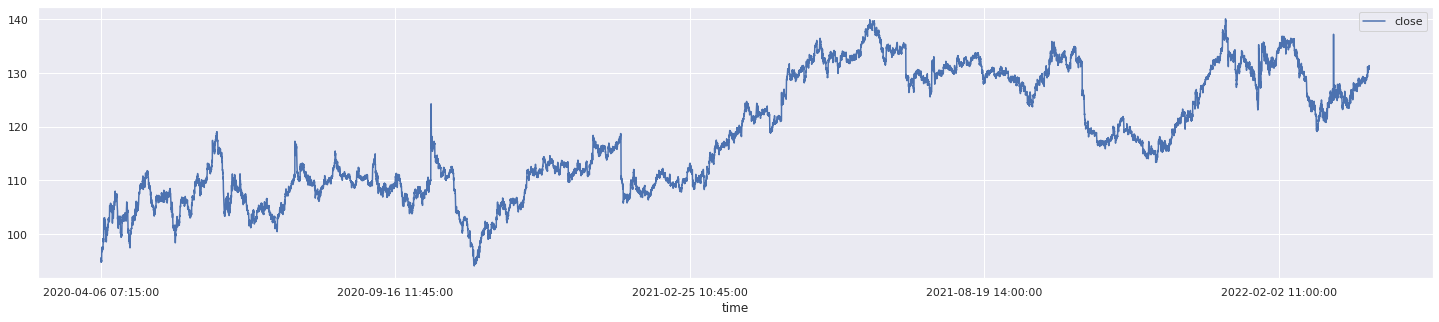

In [6]:
close_ds_rev.plot(x='time', y='close', figsize=(25, 5))

In [7]:
# converting time serires into a supervised learning problem
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
# n_in ---> number of previous data points (lag observations) to consider as input
# n_out --> number of datapoints to predict
# dataset ----> dataframe with (n_in + n_out + 1 [for current timestamp]) numbers of columns used for supervised training of the model 

n_in = 50
n_out = 1
dataset = series_to_supervised(close_ds_rev.drop('time', axis=1), n_in, n_out)
print(dataset.shape)
dataset.head()

(21490, 52)


,close(t-50),close(t-49),close(t-48),close(t-47),close(t-46),close(t-45),close(t-44),close(t-43),close(t-42),close(t-41),...,close(t-8),close(t-7),close(t-6),close(t-5),close(t-4),close(t-3),close(t-2),close(t-1),close(t),close(t+1)
50,94.703037,95.557695,95.013822,95.177847,94.746202,95.022455,94.962024,94.962024,94.962024,94.875695,...,98.458353,98.915898,99.123088,102.904303,102.041012,101.989214,102.731645,102.291366,102.593518,101.876986
51,95.557695,95.013822,95.177847,94.746202,95.022455,94.962024,94.962024,94.962024,94.875695,96.084303,...,98.915898,99.123088,102.904303,102.041012,101.989214,102.731645,102.291366,102.593518,101.876986,102.299999
52,95.013822,95.177847,94.746202,95.022455,94.962024,94.962024,94.962024,94.875695,96.084303,97.500100,...,99.123088,102.904303,102.041012,101.989214,102.731645,102.291366,102.593518,101.876986,102.299999,101.980581
53,95.177847,94.746202,95.022455,94.962024,94.962024,94.962024,94.875695,96.084303,97.500100,97.317255,...,102.904303,102.041012,101.989214,102.731645,102.291366,102.593518,101.876986,102.299999,101.980581,102.774809
54,94.746202,95.022455,94.962024,94.962024,94.962024,94.875695,96.084303,97.500100,97.317255,97.059822,...,102.041012,101.989214,102.731645,102.291366,102.593518,101.876986,102.299999,101.980581,102.774809,102.222303


In [9]:
# train test split

from sklearn.model_selection import train_test_split
target = dataset.loc[:, ['close(t+1)']]
features = dataset.drop('close(t+1)', axis=1)
print(target.shape)
print(features.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(21490, 1)
(21490, 51)
(15043, 51)
(15043, 1)
(6447, 51)
(6447, 1)


In [10]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (15043, 51, 1)
Validation set shape (6447, 51, 1)


In [15]:
# Model training

from tensorflow import keras 
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Bidirectional, ConvLSTM2D

# Vanilla lstm

model_lstm_vanilla = Sequential()
model_lstm_vanilla.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_vanilla.add(Dense(1))
model_lstm_vanilla.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.0003))
model_lstm_vanilla.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
# Stacked LSTM

model_lstm_stacked = Sequential()
model_lstm_stacked.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_stacked.add(LSTM(50, activation='relu'))
model_lstm_stacked.add(Dense(1))
model_lstm_stacked.compile(optimizer='adam', loss='mse')
model_lstm_stacked.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 51, 50)            10400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Bidirectional LSTM

model_lstm_bidirectional = Sequential()
model_lstm_bidirectional.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_bidirectional.add(Dense(1))
model_lstm_bidirectional.compile(optimizer='adam', loss='mse')
model_lstm_bidirectional.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              20800     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm_vanilla_history = model_lstm_vanilla.fit(X_train_series, y_train.values, validation_data=(X_test_series, y_test.values), epochs=30, verbose=2)

Epoch 1/30
471/471 - 55s - loss: 3877.8669 - val_loss: 2421.3765 - 55s/epoch - 117ms/step
Epoch 2/30
471/471 - 54s - loss: 1990.1376 - val_loss: 2211.0339 - 54s/epoch - 114ms/step
Epoch 3/30
471/471 - 53s - loss: 602.5469 - val_loss: 150.0188 - 53s/epoch - 114ms/step
Epoch 4/30
471/471 - 54s - loss: 50.0558 - val_loss: 61.3152 - 54s/epoch - 115ms/step
Epoch 5/30
471/471 - 55s - loss: 26.1684 - val_loss: 52.2761 - 55s/epoch - 116ms/step
Epoch 6/30
471/471 - 54s - loss: 22.0413 - val_loss: 43.0738 - 54s/epoch - 114ms/step
Epoch 7/30
471/471 - 54s - loss: 18.0529 - val_loss: 34.1859 - 54s/epoch - 115ms/step
Epoch 8/30
471/471 - 54s - loss: 14.3173 - val_loss: 26.6838 - 54s/epoch - 115ms/step
Epoch 9/30
471/471 - 54s - loss: 11.1944 - val_loss: 20.6206 - 54s/epoch - 115ms/step
Epoch 10/30
471/471 - 54s - loss: 8.6082 - val_loss: 15.3931 - 54s/epoch - 115ms/step
Epoch 11/30
471/471 - 54s - loss: 6.5002 - val_loss: 11.2708 - 54s/epoch - 115ms/step
Epoch 12/30
471/471 - 54s - loss: 4.8861 - v

In [ ]:
model_lstm_stacked_history = model_lstm_stacked.fit(X_train_series, y_train.values, validation_data=(X_test_series, y_test.values), epochs=30, verbose=2)

In [ ]:
model_lstm_bidirectional_history = model_lstm_bidirectional.fit(X_train_series, y_train.values, validation_data=(X_test_series, y_test.values), epochs=30, verbose=2)

Text(0, 0.5, 'MSE')

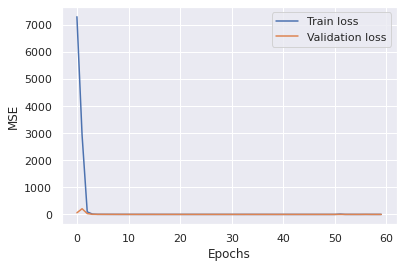

In [ ]:
# plots 
# fig = plt.figure()
# plt.plot(lstm_history.history['loss'], label='Train loss')
# plt.plot(lstm_history.history['val_loss'], label='Validation loss')
# plt.legend(loc='best')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')
models = [model_lstm_vanilla_history, model_lstm_stacked_history, model_lstm_bidirectional_history]
model_names = ['Vanilla LSTM', 'Stacked LSTM', 'Bidirectional LSTM']
fig, axs = plt.subplots(3)
for i in range(0, 3):
    axs[i].plot(models[i].history['loss'], label='Train loss')
    axs[i].plot(models[i].history['val_loss'], label='Validation loss')
    axs[i].legend(loc='binest')
    axs[i].xlabel('Epochs')
    axs[i].ylabel('MSE')
    axs[i].title(model_names[i])


In [ ]:
# RMSE calculation
from sklearn.metrics import mean_squared_error
lstm_train_pred = model_lstm.predict(X_train.values)
lstm_test_pred = model_lstm.predict(X_test.values)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, lstm_test_pred)))

Train rmse: 0.668494664125958
Validation rmse: 0.6719592218872301
